# ARIMA Single Model

---

In [42]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

# Lasso
from sklearn.linear_model import Lasso

# Save the log
import os
import pickle
import time
from datetime import timedelta
# EEMD
from PyEMD import EEMD

# ARIMA
from pmdarima.arima import auto_arima

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [43]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rcParams['font.family'] = 'Malgun Gothic'

## Data Explore

In [44]:
df = pd.read_csv("../Data/All_capstone_df.csv")
df['Date'] = pd.to_datetime(df['Date'])

---

In [45]:
def lasso_feature_selection(df):
    tmp_df = df.drop(columns=['Date','Product', '년월'])
    # 데이터프레임에서 y값 열 추출
    y = tmp_df.loc[:, 'y']
    
    # 데이터프레임에서 y값 열을 제외한 나머지 열을 X로 설정
    X = tmp_df.drop(columns='y')
    
    # Lasso 회귀 모델 생성
    lasso = Lasso(alpha=10)  # alpha 값을 조절하여 정규화 강도 조절 가능
    
    # 모델 훈련
    lasso.fit(X, y)
    
    # 각 변수의 계수 출력
    coefficients = pd.Series(lasso.coef_, index=X.columns)
    print("각 변수의 계수:")
    print(coefficients)
    
    # 선택된 변수만 보여주기
    selected_var = coefficients[coefficients != 0]
    print("\n선택된 변수:")
    print(selected_var)
    
    return selected_var.index.tolist()

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [46]:
# train과 test로 데이터 split
def split_data(product_df):
    
    train_df = product_df[product_df['Date']<'2022-07-01'].reset_index(drop=True)
    test_df = product_df[product_df['Date']>='2022-07-01'].reset_index(drop=True)
    return train_df, test_df

## ARIMA
- Rolling forecast 방식으로 input값으로 테스트 기간의 값이 들어가서, 1일 후를 예측한 것을 총 6개월 이어붙임

In [47]:
# Rolling Forecasting
def ARIMA_single(product_df):

    train_df, test_df = split_data(product_df)
    
    selected_features = lasso_feature_selection(product_df)
    
    predictions = []
    best_model = auto_arima(train_df['y'], X=train_df[selected_features],
                            start_p=1, start_q=1,
                            max_p=5, max_q=5, 
                            max_d=2, trace=True,
                            suppress_warnings=True)
    
    for test_date in test_df['Date']:
        print(test_date)
        
        test_date_prev_1 = test_date - pd.Timedelta(days=1)
        train_until_test_df = product_df[product_df['Date'] <= test_date_prev_1]
        
        best_model_fit = best_model.fit(train_until_test_df['y'], X=train_until_test_df[selected_features])
        
        # Using exogenous variables of the day before the test date for prediction
        exog_for_pred = train_until_test_df[train_until_test_df['Date'] == test_date_prev_1][selected_features].values.reshape(1, -1)
        prediction = best_model_fit.predict(n_periods=1, X=exog_for_pred).iloc[0]
        predictions.append(max(0, prediction))

    # Create a DataFrame to hold the result
    res_df = test_df.copy()
    res_df['Pred'] = predictions
    res_df.set_index('Date', inplace=True)

    # res_df: ['y'','Pred'] index='Date'
    return best_model, res_df

## Save & Load the model

In [48]:
def save_model(product_code, best_model):
    today = date.today()
    folder_path = 'Result/Lasso+ARIMA_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(best_model, f)
    return best_model

In [49]:
# 학습된 모델 pickle파일에서 불러오기
def load_model(file_name):
    file_path = f'Result/Lasso+ARIMA_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return best_model

## Plot the result

In [50]:
def actual_pred_plot(product_code, res_df, metric_df):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    save_path = os.path.join("Result", "Lasso+ARIMA_Result", product_code)
    save_name = f'{product_code}_all_result'
    
    title = f"Pred Actual Plot - {product_code}"
    actual = res_df['y']
    pred = res_df['Pred']

    # Plot   
    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)
    plt.plot(actual, label ='Actual', color='r', marker='o', ms=3)
    plt.plot(pred, label='Prediction', color='b', marker='o', ms=3)
    plt.legend(loc="upper right")
        
    # Plot 결과 저장
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # save the figure
    today_date = f'_{today.month:02d}{today.day:02d}'
    plt.savefig(os.path.join(save_path, save_name+'.png'))
    plt.show()
    
    # 전체 결과에 대한 Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, save_name+'.csv'), encoding="utf-8-sig")
    plt.close('all') # close all figures to free up memory

## Metrics

In [51]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [52]:
def calculate_metrics(product_code, res_df):

    actual = res_df['y']
    pred = res_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)

    # 계산된 메트릭을 데이터프레임에 추가
    metric_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]},
                            index= [product_code])

    return metric_df

---

## Check the Result

In [53]:
def execute_single_ARIMA(product_code):
    start_time = time.time()
    
    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product']== product_code].reset_index(drop=True)

    # Prophet 단일 모델
    best_model, res_df = ARIMA_single(product_df) 
    save_model(product_code, best_model)
    # 모델 Metric과 Pred_Actual Plot 저장
    metric_df= calculate_metrics(product_code, res_df)
    actual_pred_plot(product_code, res_df, metric_df)
    
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

========== 2210 ==========
각 변수의 계수:
월                         0.000000
일                        -8.863931
요일                     -256.757065
공휴일여부                  -966.182850
소비자물가지수(2020＝100)_전국    -49.522911
기업경기실사지수(실적)_제 조 업      -10.815540
기업경기실사지수(전망)_제 조 업       -2.435282
경제심리지수_경제심리지수(순환변동치)     -0.000000
경제심리지수_경제심리지수(원계열)       13.225752
설비투자지수_총지수               -1.334700
수입물가지수(기본분류)_총지수          3.155274
수출물가지수(기본분류)_총지수         -0.000000
평균기온(°C)                -15.334719
일강수량(mm)                 -1.321369
평균 풍속(m/s)                0.000000
dtype: float64

선택된 변수:
일                        -8.863931
요일                     -256.757065
공휴일여부                  -966.182850
소비자물가지수(2020＝100)_전국    -49.522911
기업경기실사지수(실적)_제 조 업      -10.815540
기업경기실사지수(전망)_제 조 업       -2.435282
경제심리지수_경제심리지수(원계열)       13.225752
설비투자지수_총지수               -1.334700
수입물가지수(기본분류)_총지수          3.155274
평균기온(°C)                -15.334719
일강수량(mm)                 -1.321369
dtype: float64
Performing ste

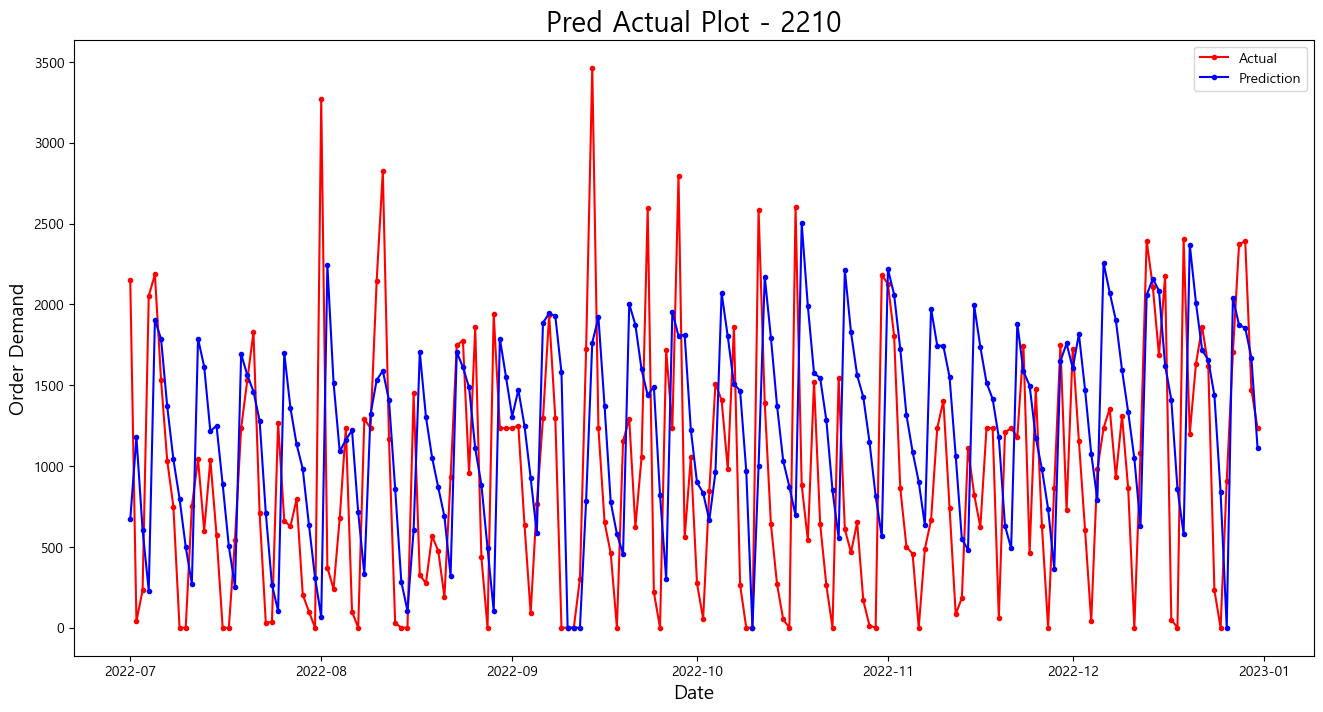

실행 시간: 2.54 분
========== 2213 ==========
각 변수의 계수:
월                         28.810993
일                         -8.037303
요일                      -322.149703
공휴일여부                  -1284.726226
소비자물가지수(2020＝100)_전국     -51.703245
기업경기실사지수(실적)_제 조 업       -23.703238
기업경기실사지수(전망)_제 조 업         8.145244
경제심리지수_경제심리지수(순환변동치)      10.469534
경제심리지수_경제심리지수(원계열)        15.179632
설비투자지수_총지수                -4.616955
수입물가지수(기본분류)_총지수         -13.542513
수출물가지수(기본분류)_총지수          16.612722
평균기온(°C)                 -14.533442
일강수량(mm)                  -3.122740
평균 풍속(m/s)                 0.000000
dtype: float64

선택된 변수:
월                         28.810993
일                         -8.037303
요일                      -322.149703
공휴일여부                  -1284.726226
소비자물가지수(2020＝100)_전국     -51.703245
기업경기실사지수(실적)_제 조 업       -23.703238
기업경기실사지수(전망)_제 조 업         8.145244
경제심리지수_경제심리지수(순환변동치)      10.469534
경제심리지수_경제심리지수(원계열)        15.179632
설비투자지수_총지수                -4.616955
수입물가지수(기본분류)_총지수         

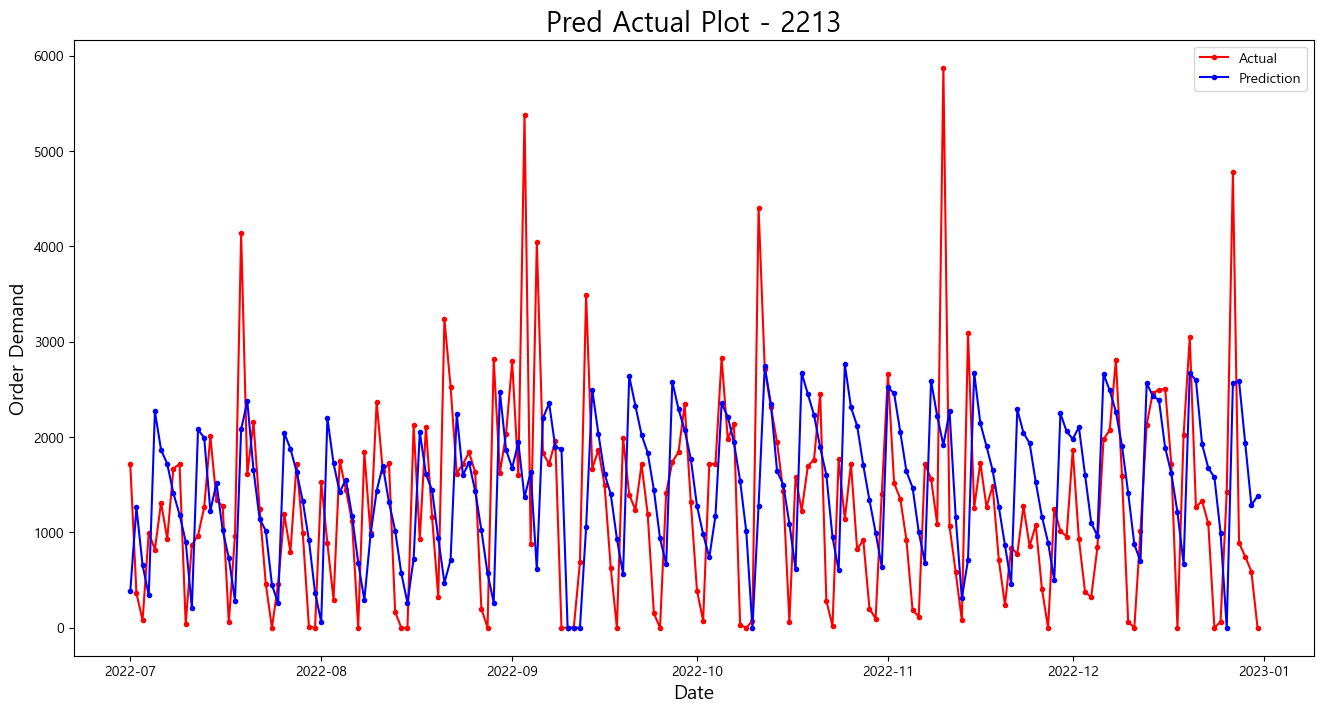

실행 시간: 3.46 분
========== 2213. ==========
각 변수의 계수:
월                       -0.067487
일                       -1.452691
요일                     -35.439840
공휴일여부                   -0.000000
소비자물가지수(2020＝100)_전국   -10.232627
기업경기실사지수(실적)_제 조 업      -2.246442
기업경기실사지수(전망)_제 조 업       1.865557
경제심리지수_경제심리지수(순환변동치)     0.189229
경제심리지수_경제심리지수(원계열)       0.396662
설비투자지수_총지수               0.000000
수입물가지수(기본분류)_총지수         0.429360
수출물가지수(기본분류)_총지수        -0.000000
평균기온(°C)                -2.059403
일강수량(mm)                 0.446733
평균 풍속(m/s)               0.000000
dtype: float64

선택된 변수:
월                       -0.067487
일                       -1.452691
요일                     -35.439840
소비자물가지수(2020＝100)_전국   -10.232627
기업경기실사지수(실적)_제 조 업      -2.246442
기업경기실사지수(전망)_제 조 업       1.865557
경제심리지수_경제심리지수(순환변동치)     0.189229
경제심리지수_경제심리지수(원계열)       0.396662
수입물가지수(기본분류)_총지수         0.429360
평균기온(°C)                -2.059403
일강수량(mm)                 0.446733
dtype: float64
Performing stepwise searc

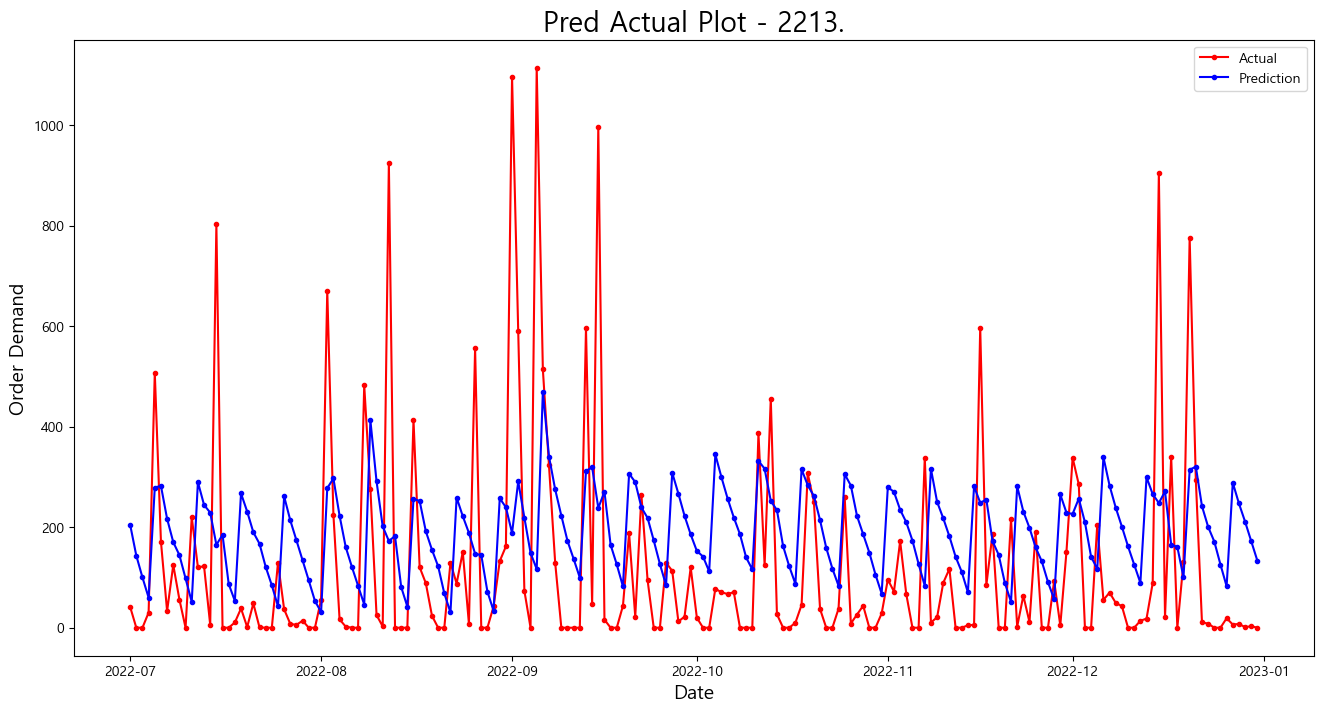

실행 시간: 4.05 분
========== 2220 ==========
각 변수의 계수:
월                        4.840647
일                       -2.014106
요일                     -57.121753
공휴일여부                  -81.454464
소비자물가지수(2020＝100)_전국    -9.619082
기업경기실사지수(실적)_제 조 업      -3.604379
기업경기실사지수(전망)_제 조 업      -3.386160
경제심리지수_경제심리지수(순환변동치)    -0.000000
경제심리지수_경제심리지수(원계열)       4.068478
설비투자지수_총지수              -0.222691
수입물가지수(기본분류)_총지수         0.000000
수출물가지수(기본분류)_총지수         4.764502
평균기온(°C)                -3.992205
일강수량(mm)                 0.057862
평균 풍속(m/s)               0.000000
dtype: float64

선택된 변수:
월                        4.840647
일                       -2.014106
요일                     -57.121753
공휴일여부                  -81.454464
소비자물가지수(2020＝100)_전국    -9.619082
기업경기실사지수(실적)_제 조 업      -3.604379
기업경기실사지수(전망)_제 조 업      -3.386160
경제심리지수_경제심리지수(원계열)       4.068478
설비투자지수_총지수              -0.222691
수출물가지수(기본분류)_총지수         4.764502
평균기온(°C)                -3.992205
일강수량(mm)                 0.057862
dtype: 

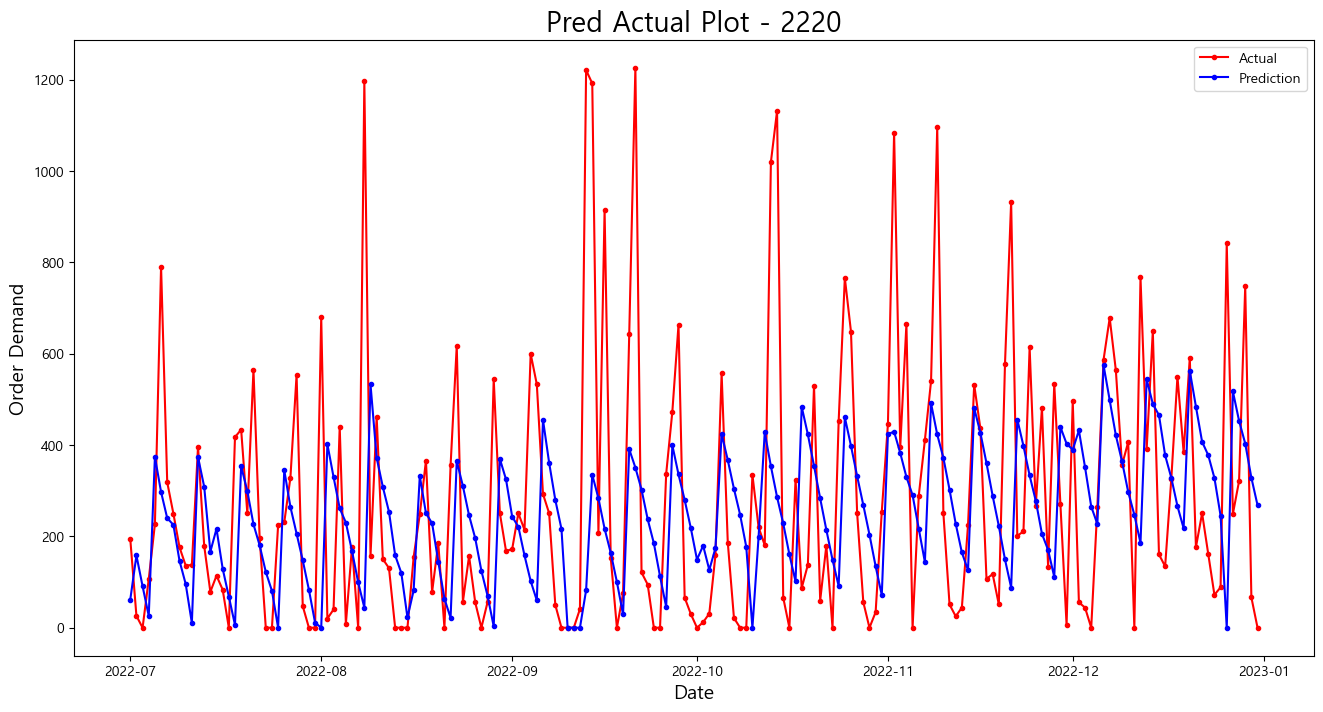

실행 시간: 12.68 분
========== 2221 ==========
각 변수의 계수:
월                        38.890520
일                        -7.518748
요일                     -166.032564
공휴일여부                  -567.990459
소비자물가지수(2020＝100)_전국    -19.447535
기업경기실사지수(실적)_제 조 업      -19.910804
기업경기실사지수(전망)_제 조 업        4.725262
경제심리지수_경제심리지수(순환변동치)     -2.297115
경제심리지수_경제심리지수(원계열)       19.820225
설비투자지수_총지수               -6.272636
수입물가지수(기본분류)_총지수        -11.204678
수출물가지수(기본분류)_총지수         14.922795
평균기온(°C)                -12.370558
일강수량(mm)                 -1.900424
평균 풍속(m/s)               -0.000000
dtype: float64

선택된 변수:
월                        38.890520
일                        -7.518748
요일                     -166.032564
공휴일여부                  -567.990459
소비자물가지수(2020＝100)_전국    -19.447535
기업경기실사지수(실적)_제 조 업      -19.910804
기업경기실사지수(전망)_제 조 업        4.725262
경제심리지수_경제심리지수(순환변동치)     -2.297115
경제심리지수_경제심리지수(원계열)       19.820225
설비투자지수_총지수               -6.272636
수입물가지수(기본분류)_총지수        -11.204678
수출물가지수(기본분류)_총

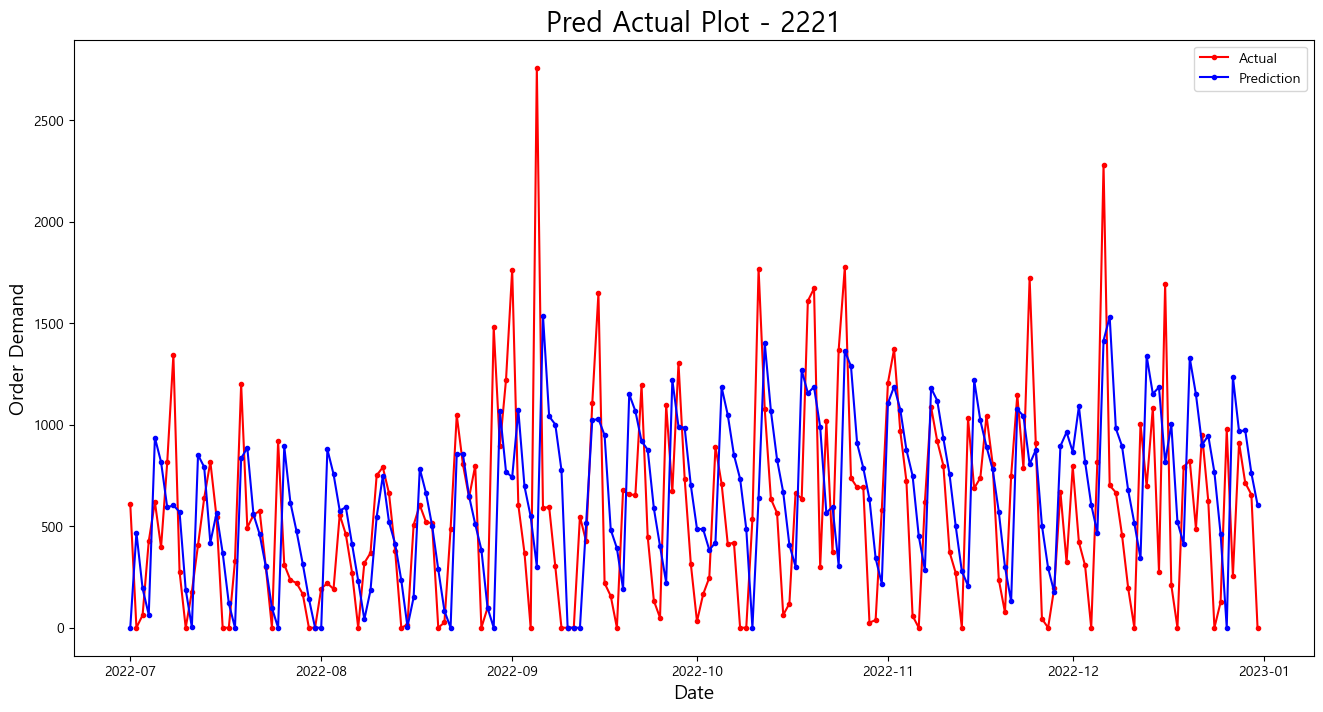

실행 시간: 13.11 분
========== 2221A ==========
각 변수의 계수:
월                       0.000000
일                       0.422755
요일                     -8.081684
공휴일여부                  -0.000000
소비자물가지수(2020＝100)_전국    0.000000
기업경기실사지수(실적)_제 조 업      0.669297
기업경기실사지수(전망)_제 조 업     -1.221290
경제심리지수_경제심리지수(순환변동치)   -0.252009
경제심리지수_경제심리지수(원계열)      0.000000
설비투자지수_총지수             -0.332614
수입물가지수(기본분류)_총지수       -0.000000
수출물가지수(기본분류)_총지수       -0.000000
평균기온(°C)                0.000000
일강수량(mm)                0.000000
평균 풍속(m/s)              0.000000
dtype: float64

선택된 변수:
일                       0.422755
요일                     -8.081684
기업경기실사지수(실적)_제 조 업      0.669297
기업경기실사지수(전망)_제 조 업     -1.221290
경제심리지수_경제심리지수(순환변동치)   -0.252009
설비투자지수_총지수             -0.332614
dtype: float64
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21275.516, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21311.073, Time=1.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : 

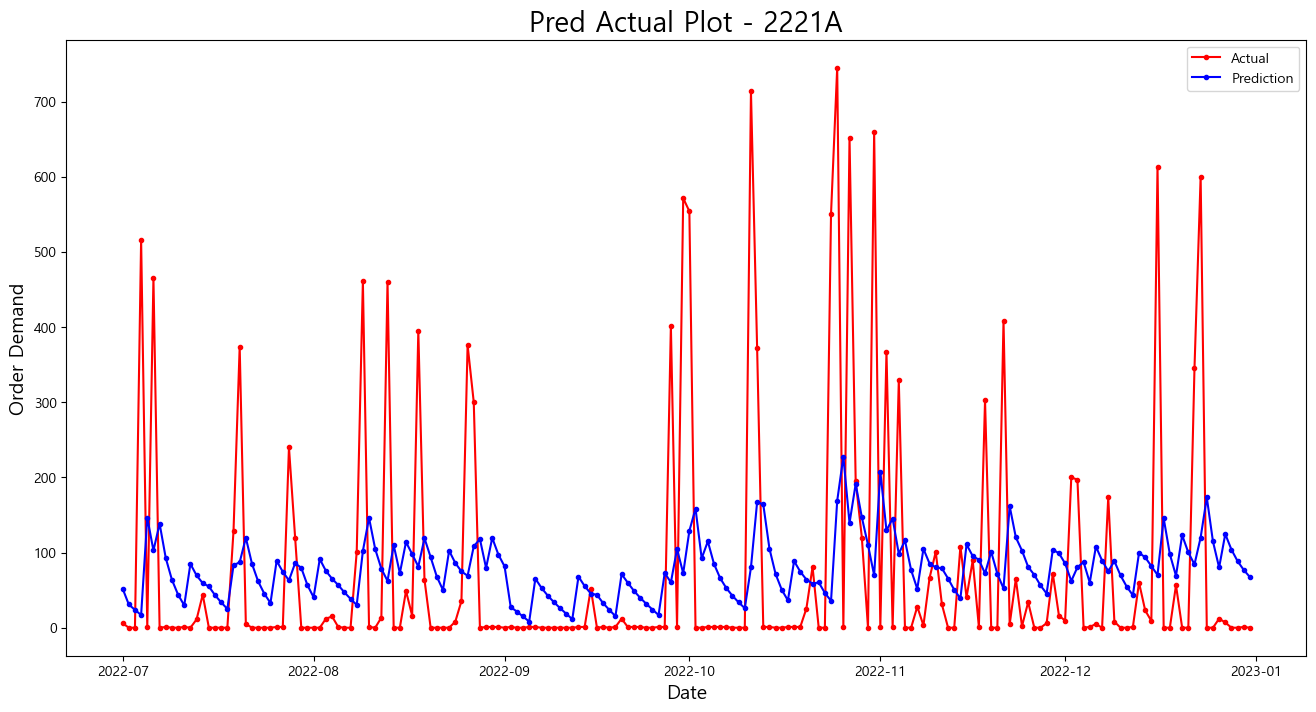

실행 시간: 3.94 분
========== 2275 ==========
각 변수의 계수:
월                       -2.325372
일                       -0.217933
요일                     -56.288915
공휴일여부                  -42.274401
소비자물가지수(2020＝100)_전국    -0.000000
기업경기실사지수(실적)_제 조 업       0.000000
기업경기실사지수(전망)_제 조 업       1.028072
경제심리지수_경제심리지수(순환변동치)    -0.215621
경제심리지수_경제심리지수(원계열)       0.000000
설비투자지수_총지수               0.016192
수입물가지수(기본분류)_총지수        -2.165906
수출물가지수(기본분류)_총지수         1.780581
평균기온(°C)                -1.925273
일강수량(mm)                -0.670498
평균 풍속(m/s)               0.000000
dtype: float64

선택된 변수:
월                       -2.325372
일                       -0.217933
요일                     -56.288915
공휴일여부                  -42.274401
기업경기실사지수(전망)_제 조 업       1.028072
경제심리지수_경제심리지수(순환변동치)    -0.215621
설비투자지수_총지수               0.016192
수입물가지수(기본분류)_총지수        -2.165906
수출물가지수(기본분류)_총지수         1.780581
평균기온(°C)                -1.925273
일강수량(mm)                -0.670498
dtype: float64
Performing stepwise search

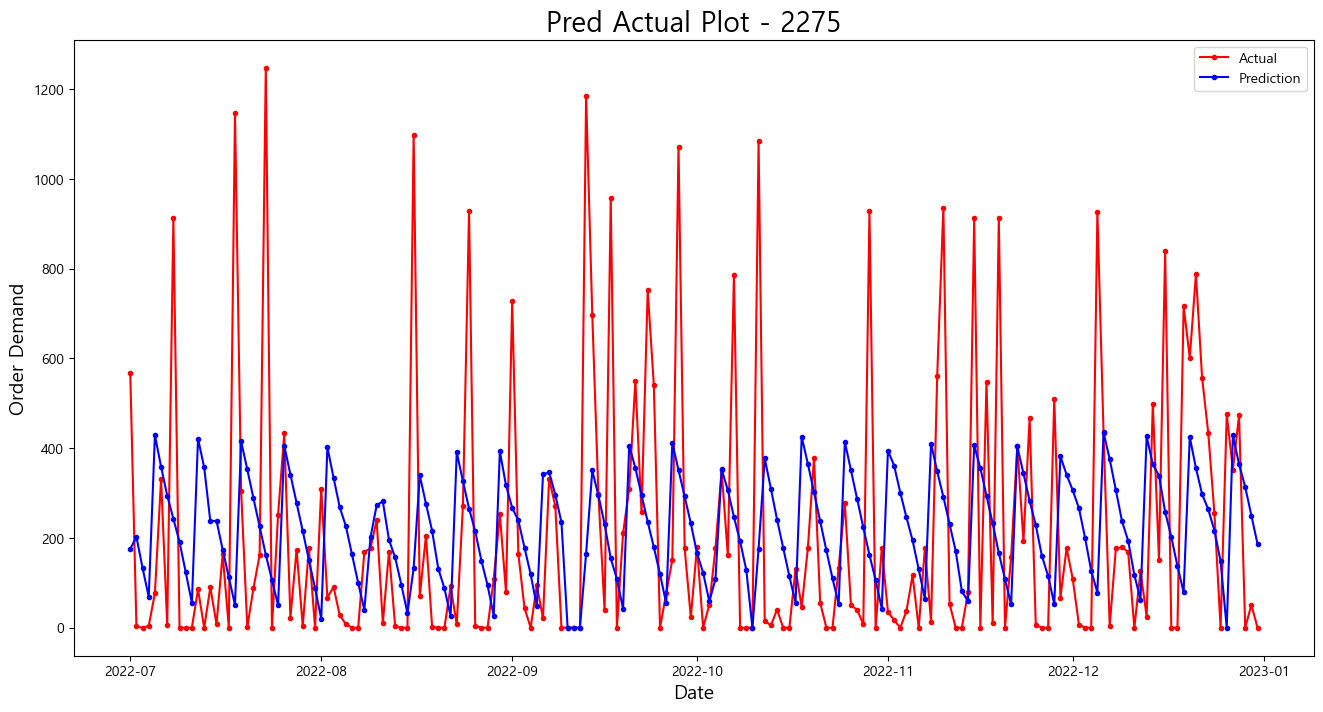

실행 시간: 8.23 분
========== 3302 ==========
각 변수의 계수:
월                        7.166936
일                        0.363957
요일                     -46.201932
공휴일여부                   -0.000000
소비자물가지수(2020＝100)_전국     0.000000
기업경기실사지수(실적)_제 조 업       3.263854
기업경기실사지수(전망)_제 조 업       0.000000
경제심리지수_경제심리지수(순환변동치)    -1.965921
경제심리지수_경제심리지수(원계열)      -3.185097
설비투자지수_총지수              -1.850501
수입물가지수(기본분류)_총지수         3.239163
수출물가지수(기본분류)_총지수        -3.242679
평균기온(°C)                -0.388613
일강수량(mm)                -0.236493
평균 풍속(m/s)              -0.000000
dtype: float64

선택된 변수:
월                        7.166936
일                        0.363957
요일                     -46.201932
기업경기실사지수(실적)_제 조 업       3.263854
경제심리지수_경제심리지수(순환변동치)    -1.965921
경제심리지수_경제심리지수(원계열)      -3.185097
설비투자지수_총지수              -1.850501
수입물가지수(기본분류)_총지수         3.239163
수출물가지수(기본분류)_총지수        -3.242679
평균기온(°C)                -0.388613
일강수량(mm)                -0.236493
dtype: float64
Performing stepwise search

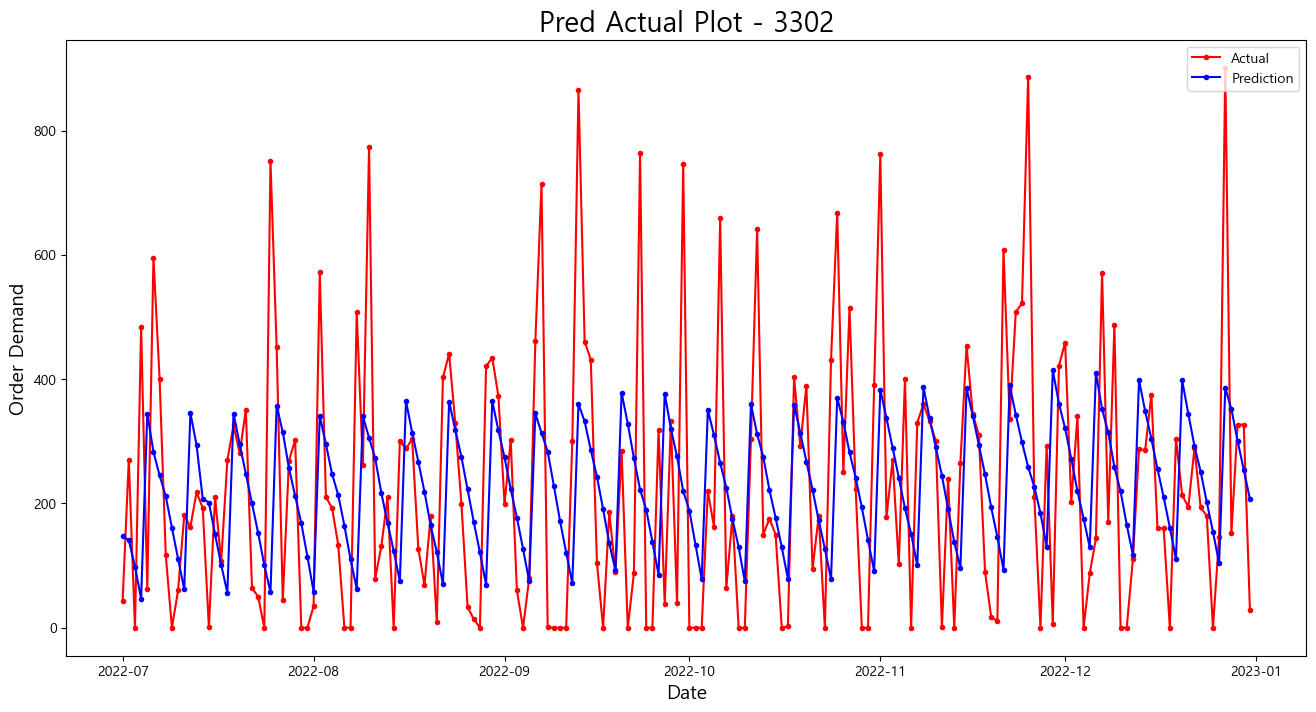

실행 시간: 10.71 분
========== 3524 ==========
각 변수의 계수:
월                         6.692796
일                        -1.088823
요일                     -131.689276
공휴일여부                  -396.584061
소비자물가지수(2020＝100)_전국    -34.144524
기업경기실사지수(실적)_제 조 업      -20.638062
기업경기실사지수(전망)_제 조 업        1.983748
경제심리지수_경제심리지수(순환변동치)     -0.000000
경제심리지수_경제심리지수(원계열)       21.899403
설비투자지수_총지수                0.297597
수입물가지수(기본분류)_총지수         -8.934881
수출물가지수(기본분류)_총지수          7.458955
평균기온(°C)                 -2.069781
일강수량(mm)                 -0.863527
평균 풍속(m/s)                0.000000
dtype: float64

선택된 변수:
월                         6.692796
일                        -1.088823
요일                     -131.689276
공휴일여부                  -396.584061
소비자물가지수(2020＝100)_전국    -34.144524
기업경기실사지수(실적)_제 조 업      -20.638062
기업경기실사지수(전망)_제 조 업        1.983748
경제심리지수_경제심리지수(원계열)       21.899403
설비투자지수_총지수                0.297597
수입물가지수(기본분류)_총지수         -8.934881
수출물가지수(기본분류)_총지수          7.458955
평균기온(°C)      

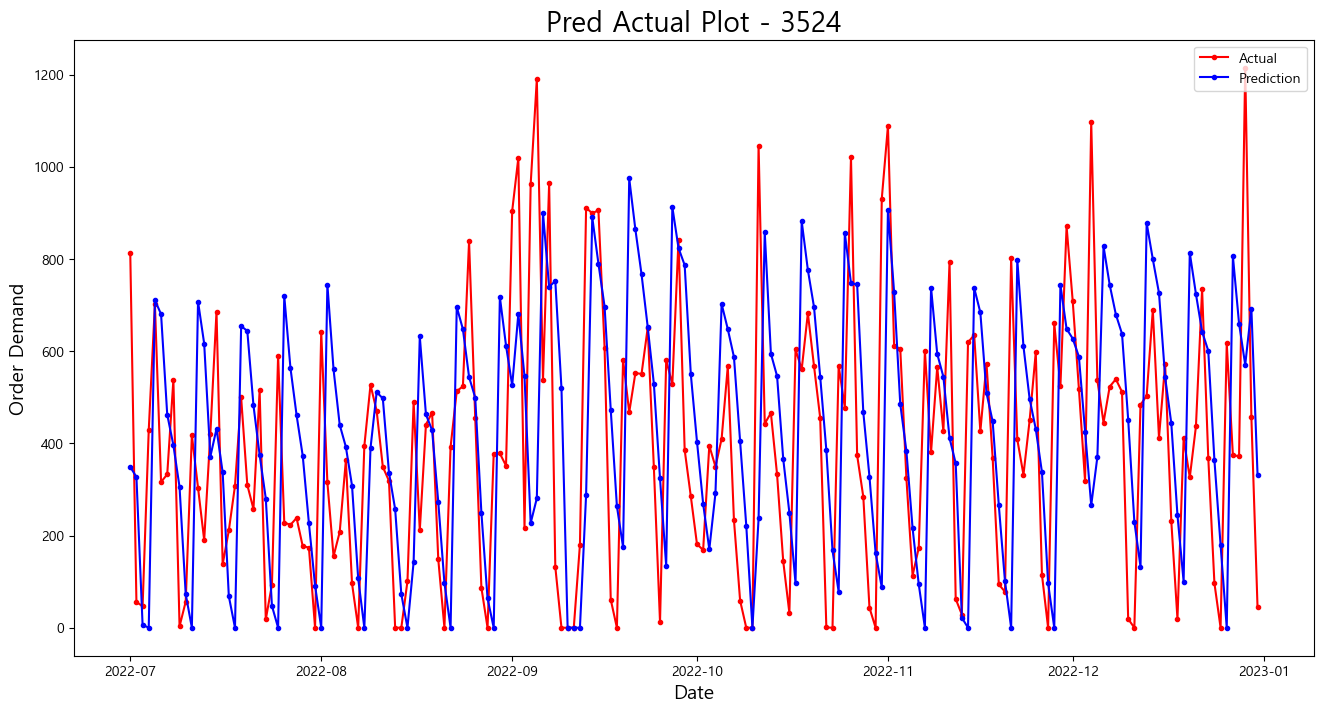

실행 시간: 17.35 분
========== 3622 ==========
각 변수의 계수:
월                        33.614979
일                        -7.987769
요일                     -215.283218
공휴일여부                  -816.778822
소비자물가지수(2020＝100)_전국    -15.769893
기업경기실사지수(실적)_제 조 업      -40.680420
기업경기실사지수(전망)_제 조 업        9.092159
경제심리지수_경제심리지수(순환변동치)    -10.547244
경제심리지수_경제심리지수(원계열)       41.623031
설비투자지수_총지수               -0.475735
수입물가지수(기본분류)_총지수        -18.223328
수출물가지수(기본분류)_총지수         26.415289
평균기온(°C)                 -6.413154
일강수량(mm)                 -0.984977
평균 풍속(m/s)               -0.000000
dtype: float64

선택된 변수:
월                        33.614979
일                        -7.987769
요일                     -215.283218
공휴일여부                  -816.778822
소비자물가지수(2020＝100)_전국    -15.769893
기업경기실사지수(실적)_제 조 업      -40.680420
기업경기실사지수(전망)_제 조 업        9.092159
경제심리지수_경제심리지수(순환변동치)    -10.547244
경제심리지수_경제심리지수(원계열)       41.623031
설비투자지수_총지수               -0.475735
수입물가지수(기본분류)_총지수        -18.223328
수출물가지수(기본분류)_총

LinAlgError: LU decomposition error.

In [54]:
all_metric = pd.DataFrame()

for code in df['Product'].unique():
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    tmp_metric = execute_single_ARIMA(code)
    all_metric = pd.concat([all_metric, tmp_metric])